# Classer avec la méthode des k-Plus Proches Voisins

Dans ce TP nous allons implémenter notre première Intelligence Artificielle à partir de la méthode des k-Plus Proches Voisins étudiée en TD. Nous allons implémenter, tester, évaluer et étudier cette méthode de classification sur un jeu de données réelles.

## A. Charger, explorer puis préparer le tableau de données

Commencez par importer dans un Dataframe `zoo` les données du fichier `zoo.csv`.

In [1]:
import pandas as pd
import numpy as np
zoo = pd.read_csv("./donnees/zoo.csv")
zoo.head(15)

,Name,hair,feathers,eggs,milk,airbone,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,size,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,115.0,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,75.0,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,40.0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,210.0,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,120.0,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,280.0,1
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,100.0,1
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,60.0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,12.0,4
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,45.0,1


Explorez le dataset `zoo`: Combien d'individus? Combien de descripteurs? Quelle est la nature (type) des descripteurs? Y-a-t'il des valeurs manquantes?

In [2]:
zoo.shape
#100 individus,

#X = les individus, Un individu = une ligne
#18 Descripteurs
#Y => une colonne, la CLASSE => Trouver la colonne qui serait intéressante pour faire la prédiction
#Ici, Y = colonne 'type'
#La classe n'est pas considéré comme Descripteurs => Il y a donc 17 DESCRIPTEURS

#Le nom n'est pas important pour la prédiction => ....

(100, 18)

Dans ce dataset, la dernière colonne `type` correspond à la catégorie de l'animal :
|  Type  |    Catégorie    |
| :---------:|---------|
| 1 |Mammifères|
| 2 |Oiseaux|
| 3 |Reptiles|
| 4 |Poissons|
| 5 |Amphibiens|
| 6 |Insectes|
| 7 |Invertébrés|

Notre IA devra prédire la catégorie d'un animal à partir de sa description (sans le `Name`). Il s'agit donc d'une tâche de prédiction à **7 classes**.

Observez la distribution des individus selon la variable de classe (`type`) et constatez le déséquilibre des classes. Cela aura-t'il une incidence sur la méthode de k-PPV?

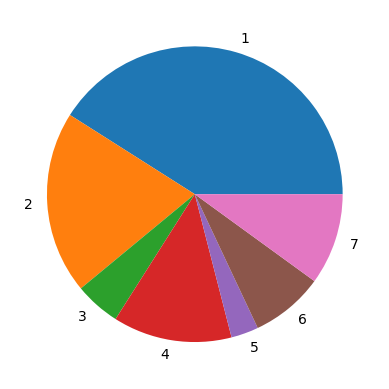

In [3]:
import matplotlib.pyplot as plt
labels, sizes = np.unique(zoo['type'], return_counts=True)
plt.pie(sizes, labels=labels)
plt.show()

A partir du dataframe `zoo`, vous allez construire deux tableaux Numpy :
- `X` est la matrice (100x16) des descriptions des individus
- `y` est le vecteur contenant les (100) catégories d'animaux 

In [4]:
X = np.array(zoo.iloc[:, 1:-1])
Y = np.array(zoo['type'])

print(X.shape)
print(Y.shape)

(100, 16)
(100,)


Nous allons à présent découper `X` et `y` en deux sous-ensembles :
- `X_train` : qui contient des individus que la méthode k-PPV utilisera pour prédire
- `X_test`  : qui contient des individus que nous utiliserons pour évaluer notre IA (et ainsi ajuster le paramètre k)
- `y_train` : qui contient les labels des individus de `X_train`
- `y_test`  : qui contient les labels des individus de `X_test`

Ecrire une fonction (générique) `train_test_split(X, y, train_ratio)` qui réalise un tel découpage :

In [30]:
def train_test_split(X, y, train_ratio):
    """découpe un dataset X en deux ensembles d'entraînement (train) et de test ainsi que les labels associés

    Args:
        X (matrice Numpy): le dataset à découper
        y (vecteur Numpy): le vecteur des labels à découper
        train_ratio (float): entre 0.0 et 1.0 = proportion du dataset à inclure dans l'ensemble d'entraînement (train)

    Returns:
        X_train (matrice Numpy): le sous-ensemble d'entraînement
        X_test (matrice Numpy):  le sous-ensemble de test
        y_train (vecteur Numpy): les labels données d'entraînement
        y_test (vecteur Numpy):  les labels données de test

    """
    #Randomiser les individus
    #Découper sur ratio * nb individus
    N = X.shape[0]
    if N != y.shape[0]:
        return None
    if train_ratio > 1 or train_ratio < 0:
        return None
    ids = np.arange(N)
    np.random.shuffle(ids)
    nb_train = int(train_ratio * N)
    train_ids, test_ids = ids[:nb_train], ids[nb_train:]
    return X[train_ids,:], X[test_ids, :], y[train_ids], y[test_ids]
    

Utilisez votre fonction pour découper notre dataset `X` en deux sous-ensembles de mêmes tailles.

Vérifiez que les déséquilibres des classes sont globalement respectés (relancez le découpage si certaines classes sont absentes dans l'un des deux sous-ensembles).

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, 0.5)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(50, 16)
(50, 16)
(array([1, 2, 3, 4, 5, 6, 7]), array([21, 10,  3,  5,  1,  4,  6]))
(array([1, 2, 3, 4, 5, 6, 7]), array([20, 10,  2,  8,  2,  4,  4]))


---

## B. Implémenter et évaluer la méthode k-PPV (non-pondérée)

Définissez une fonction `predict_kNN(k, X, y, x_new)` qui prédit la classe d'une description `x_new` par la méthodes k-PPV non-pondérée utilisée sur les données `X` de ayant pour labels `y` avec la distance Euclidienne.

In [35]:
def predict_kNN(k, X, y, x_new):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer

    Returns:
        y_new (label):  le label prédit

    """
    distances = np.linalg.norm(X - x_new, axis = 1)
    
    ids_plus_proches_voisins = distances.argsort()[:k]
    class_plus_proches_voisins = y[ids_plus_proches_voisins]
    labels, counts = np.unique(class_plus_proches_voisins, return_counts=True)
    return labels[counts.argsort()[-1]]

Utilisez la fonction `predict_kNN` pour prédire la classe de l'individu situé à l'indice 23 dans `X_test` à partir des données d'entraînement (`X_train`, `y_train`). Affichez la classe prédite selon différentes valeurs de `k` et comparez avec la vraie classe de l'individu (`y_test[23]`). 

In [36]:
i = 23
print(Y[i])
print([predict_kNN(k, X_train, y_train, X_test[i]) for k in range(1, 21)])

2
[2, 2, 3, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Définissez une fonction `error_kNN(k, X_train, y_train, X_test, y_test)` qui renvoie le taux d'erreur de prédiction de la méthode k-PPV sur des données de test. 

In [40]:
def error_kNN(k, X_train, y_train, X_test, y_test,):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    predictions = [predict_kNN(k, X_train, y_train, X_test[i, :]) for i in range(len(y_test))]
    return 1 - sum(predictions==y_test) / len(y_test)

Tracez la courbe du taux d'erreur en fonction du paramètre `k`. Quelle valeur choisirez-vous pour `k`? Est-ce que votre classifieur vous semble performant?

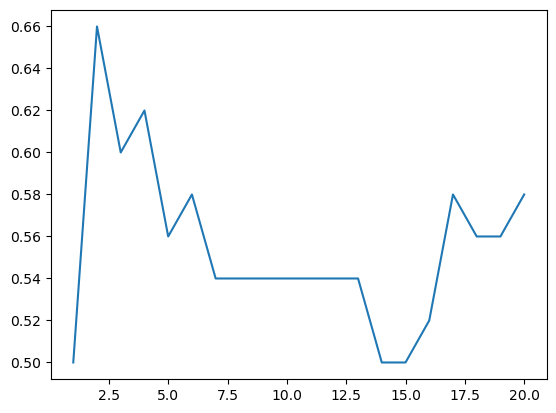

In [41]:
errors = [error_kNN(k, X_train, y_train, X_test, y_test) for k in range(1, 21)]
plt.plot(range(1,21), errors)
plt.show()

Avant de conclure (trop vite!)... quel serait le taux d'erreur d'un classifieur k-PPV qui fonderait ses prédictions sur la taille des animaux uniquement (descripteur `size`)?

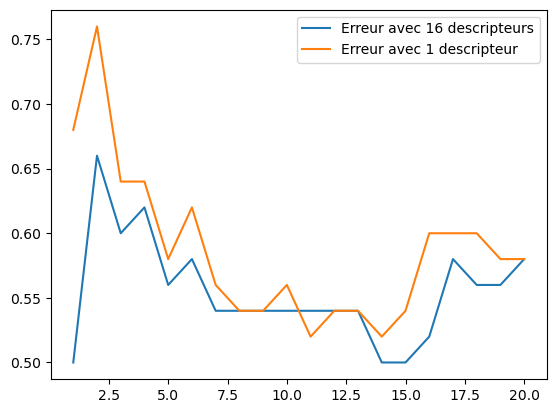

In [43]:
errors_2 = [error_kNN(k, X_train[:, -1].reshape(50,1), y_train, X_test[:, -1].reshape(50,1), y_test) for k in range(1, 21)]
plt.plot(range(1, 21), errors, label="Erreur avec 16 descripteurs")
plt.plot(range(1, 21), errors_2, label="Erreur avec 1 descripteur")
plt.legend()
plt.show()

## C. Normaliser les données

Vous avez constaté que tous les descriteurs n'ont pas la même influence dans le calcul des distances entre individus, du fait de l'amplitude des valeurs associée à chaque descripteurs.

Pour faire en sorte que chaque descripteur ait la même influence dans le traitement du tableau de données, on procède à une **normalisation** des données. 

> Normaliser un ensemble $Z$ consiste à ramener toutes ses valeurs dans l'intervalle $[0,1]$ par l'opération : $$\tilde{z}_{i}=\frac{z_{i}-min_Z}{max_Z-min_Z}$$
>

Complétez la classe `Normalizer` ci-dessous qui définit un **outil** de normalisation d'un jeu de données. La normalisation d'un jeu de données procédera en deux temps :
- calcul des paramètres de la fonction de normalisation sur des données (méthode `.fit()`)
- application de la fonction de normalisation sur des données (méthode `.transform()`)

In [44]:
class Normalizer:
    
    min = None
    max = None
    
    def fit(self, X):
        """calcule les min et max de chaque colonne de X"""
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        
    def transform(self, X):
        """renvoie X normalisé"""
        if self.min is not None and self.max is not None:
            return (X - self.min) / (self.max - self.min)

Appliquez la normalisation sur l'ensemble des individus (100 descriptions) puis comparez l'erreur faite par la méthode des k-PPV avant et après normalisation. Concluez sur l'utilité de cette étape de normalisation.

In [45]:
norm = Normalizer()
norm.fit(X)

In [46]:
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

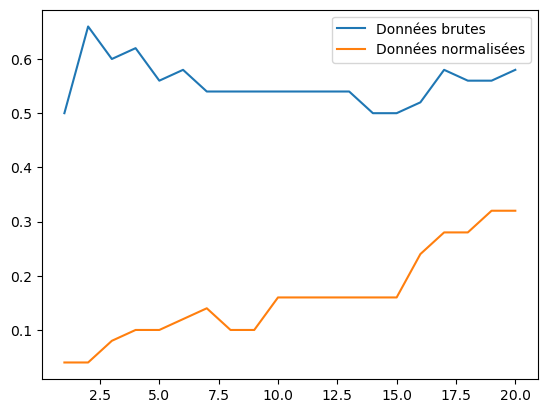

In [48]:
errors_norm = [error_kNN(k, X_train_norm, y_train, X_test_norm, y_test) for k in range(1, 21)]
plt.plot(range(1, 21), errors, label = "Données brutes")
plt.plot(range(1, 21), errors_norm, label = "Données normalisées")
plt.legend()
plt.show()

## D. Implémenter et évaluer la méthode k-PPV pondérée

Implémentez la variante pondérée de la méthode k-PPV dans une version généralisée de la fonction `predict_kNN(k, X, y, x_new, weights)`

In [57]:
def predict_kNN(k, X, y, x_new, weights='uniform'):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer
        weights ('uniform', 'distance') : méthode de pondération utilisée pour la prédiction

    Returns:
        y_new (label):  le label prédit

    """
    distances = np.linalg.norm(X - x_new, axis=1)
    ids_plus_proches_voisins = y[ids_plus_proches_voisins]
    if weights == 'uniform':
        w = np.ones(k)
    elif weights == 'distance':
        epsilon = 10e-10
        w = 1/(distances[ids_plus_proches_voisins] - epsilon)
    counts = np.bincount(classes_plus_proches_voisins, weights = w)
    return counts.argsort()[-1]

version pondérée = on calcul en plus le poids

Généralisez également la fonction d'évaluation `error_kNN(k, X_train, y_train, X_test, y_test, weights)` avec l'argument supplémentaire `weights`

In [58]:
def error_kNN(k, X_train, y_train, X_test, y_test, weights='uniform'):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test
        weights ('uniform', 'distance') : méthode de pondération utilisée dans k-PPV


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    predictions = [predict_kNN(k, X_train, y_train, X_test[i, :], weights=weights) for i in range(len(y_test))]
    return 1 - sum(predictions==y_test) / len(y_test)

Enfin, comparez l'erreur faite par chacune des deux versions de la méthode k-PPV (pondérée ou non).

In [59]:
error_unifor = [error_kNN(k, X_train_norm, y_train, X_test_norm, y_test) for k in range(1, 21)]
error_weighted = [error_kNN(k, X_train_norm, y_train, X_test_norm, y_test, weights='distance') for k in range(1, 21)]
plt.plot(range(1, 21), error_unifor, label="K-PPV uniforme")
plt.plot(range(1, 21), error_weighted, label="K-PPV pondéré")
plt.legend()
plt.show()

UnboundLocalError: cannot access local variable 'ids_plus_proches_voisins' where it is not associated with a value